<a href="https://colab.research.google.com/github/JoshuaChung93/Cryptocurrency-trading-bot/blob/main/BTC_IBS_strategy_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df0 = pd.read_csv('/content/drive/MyDrive/BTC historical dataset/BTC-Hourly.csv', index_col=0)

In [224]:
df = df0.copy()

In [225]:
# 시계열에 맞게 인덱스를 거꾸로 돌려줍니다
df = df.loc[::-1].reset_index(drop=True)
df.head()

,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
1,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
2,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
3,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
4,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [226]:
# 인덱스 이름 설정
df.index.name = 'Bar numbers'
# 필요 없는 열 드랍하기
df.drop(['Volume BTC','Volume USD'], axis=1, inplace=True)
df.tail()

,date,symbol,open,high,low,close
Bar numbers,,,,,,
33254,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97
33255,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53
33256,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32
33257,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98
33258,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27


In [236]:
import copy

# df1 = copy.deepcopy(df)
df = df1.copy()

## 백테스트 기간 주가 그래프

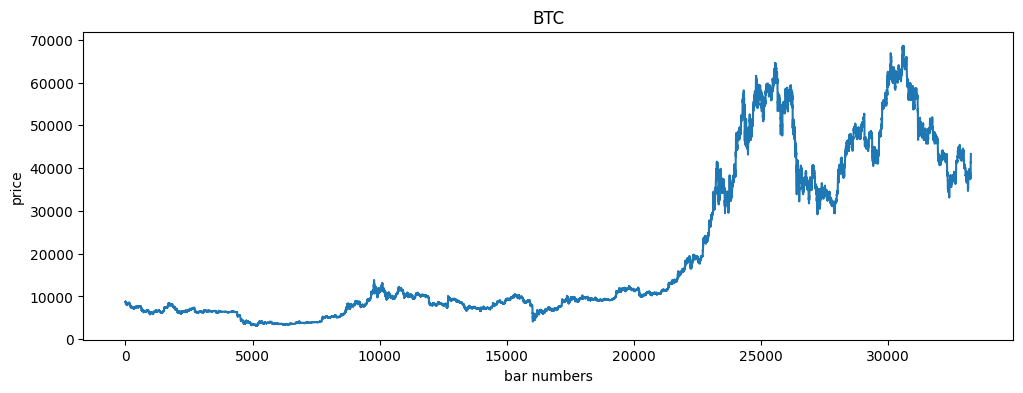

In [228]:
plt.style.use(['default'])
df['close'].plot(figsize=(12,4), title='BTC')
plt.xlabel('bar numbers')
plt.ylabel('price')

plt.show()

In [259]:
# 100SMA, 200SMA 칼럼 생성
df['200SMA'] = df['close'].rolling(4800).mean()
df['100SMA'] = df['close'].rolling(2400).mean()
df.head()

,date,symbol,open,high,low,close,long,short,position_short,ror_short,total_short,50SMA,200SMA,100SMA
Bar numbers,,,,,,,,,,,,,,
0,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,False,False,0,1.0,1.0,NaN,NaN,NaN
1,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,False,False,0,1.0,1.0,NaN,NaN,NaN
2,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,False,False,0,1.0,1.0,NaN,NaN,NaN
3,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,True,False,0,1.0,1.0,NaN,NaN,NaN
4,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,False,False,0,1.0,1.0,NaN,NaN,NaN


KeyError: ignored

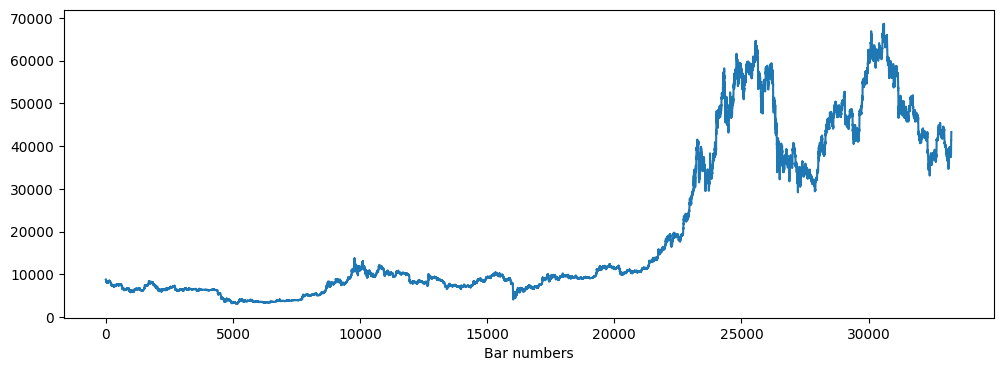

In [258]:
df['close'].plot(figsize=(12,4), label='Close')
df['100SMA'].plot(label='100hr SMA')
df['200SMA'].plot(label='200hr SMA')

plt.title('Close, 100SMA, 200SMA comparison')
plt.legend()


# make signal column

In [238]:
# 진입조건을 위한 칼럼 생성
df['long'] = (df['close'] - df['low'])/(df['high'] - df['low']) < 0.2
df['short'] = (df['close'] - df['low'])/(df['high'] - df['low']) > 0.8
df['long_con'] = (df['close']) <= (1.05*df['100SMA'])
df['short_con'] = (df['close']) >= (0.95*df['100SMA'])

In [232]:
# long 진입청산 컬럼 생성
df['entry_long'] = np.where((df['long']==True)&(df['long_con']==True), 1.0,0.0) # 진입신호
df['exit_long'] = np.where(df['short']==True, 1.0,0.0) # 청산신호

In [76]:
# 포지션 보유 여부 컬럼 생성
df['position'] = df['entry_long'] - df['exit_long']

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position"]):
    if lastseen == 0 and el == -1:
        df.loc[n,'position'] = 0
    
    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position"] = 0
# # deal with edge case
# df.loc[7,'position'] = 0

In [77]:
df.loc[(df.position==1)|(df.position==-1),:]

,date,symbol,open,high,low,close,long,short,entry_short,exit_short,200SMA,100SMA,long_con,short_con,entry_long,exit_long,position
Bar numbers,,,,,,,,,,,,,,,,,
2408,2018-08-23 14:00:00,BTC/USD,6426.14,6495.00,6426.14,6439.74,True,False,0.0,1.0,NaN,7021.826508,True,False,1.0,0.0,1.0
2415,2018-08-23 21:00:00,BTC/USD,6414.54,6480.00,6414.54,6472.57,False,True,1.0,0.0,NaN,7015.744888,True,False,0.0,1.0,-1.0
2420,2018-08-24 02:00:00,BTC/USD,6498.31,6519.83,6494.31,6499.15,True,False,0.0,1.0,NaN,7011.855821,True,False,1.0,0.0,1.0
2422,2018-08-24 04:00:00,BTC/USD,6493.65,6507.99,6473.94,6501.31,False,True,1.0,0.0,NaN,7010.439483,True,False,0.0,1.0,-1.0
2429,2018-08-24 11:00:00,BTC/USD,6540.00,6570.00,6532.81,6537.99,True,False,0.0,1.0,NaN,7005.357658,True,False,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33232,2022-02-27 22:00:00,BTC/USD,37408.05,37934.27,37349.35,37832.76,False,True,1.0,0.0,49235.089852,45351.829508,True,False,0.0,1.0,-1.0
33243,2022-02-28 09:00:00,BTC/USD,38345.77,38592.84,38114.65,38125.95,True,False,0.0,1.0,49217.574175,45257.377896,True,False,1.0,0.0,1.0
33244,2022-02-28 10:00:00,BTC/USD,38114.28,38474.51,38104.13,38404.20,False,True,1.0,0.0,49216.121967,45248.984108,True,False,0.0,1.0,-1.0


# Visualize

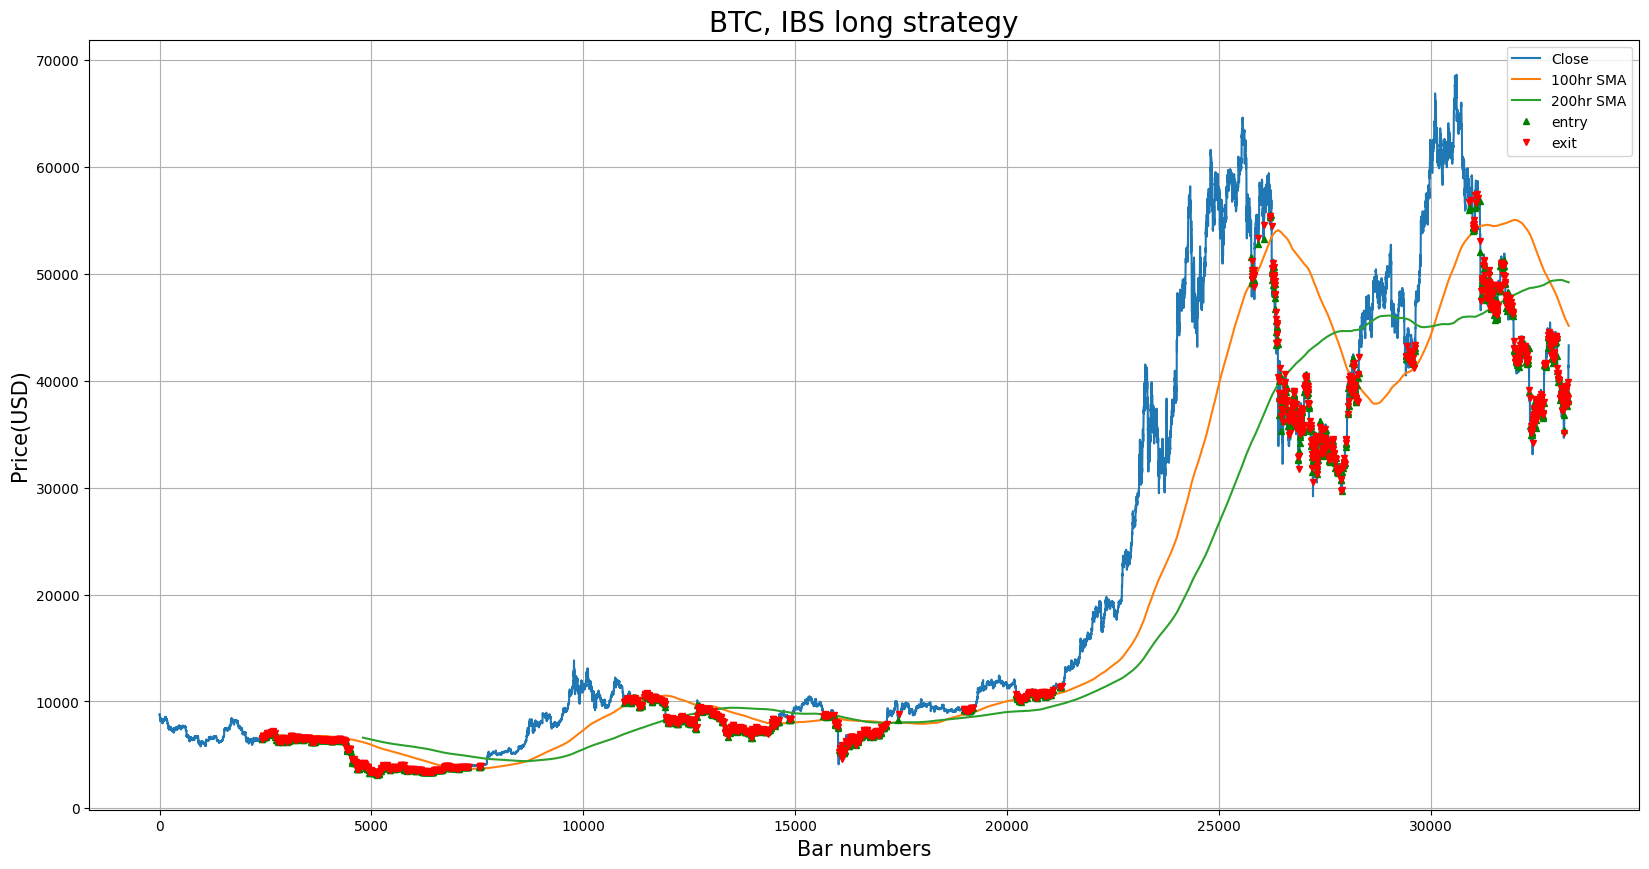

In [78]:
# plot close, 100SMA, 200SMA
df['close'].plot(figsize=(20,10), label='Close')
df['100SMA'].plot(label='100hr SMA')
df['200SMA'].plot(label='200hr SMA')

# plot 'entry' signals
plt.plot(df.loc[df['position']==1,:].index, df.loc[df['position']==1.0,'close'], '^', markersize = 5, color = 'g', label = 'entry')

# plot 'exit' signals
plt.plot(df.loc[df['position']==-1,:].index, df.loc[df['position']==-1.0,'close'], 'v', markersize = 5,  color = 'r', label = 'exit')
plt.ylabel('Price(USD)', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS long strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

# Calculate the return

In [79]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position==1)|(df.position==-1),:]
df2['exit_close'] = df2['close'].shift(-1)
# calculate return
df2['ror'] = df2['exit_close']/df2['close']

<ipython-input-79-c0217c67bcb2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_close'] = df2['close'].shift(-1)
<ipython-input-79-c0217c67bcb2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ror'] = df2['exit_close']/df2['close']


In [80]:
# copy df2 ror to df ror column
df['ror'] = df2['ror']
df['ror'].fillna(1,inplace=True)
# calculate accumulated ror
df['total'] = df['ror'].cumprod()

In [90]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total'].iat[-1] / df['total'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  518.66 return(%)


In [82]:
# calculate CAGR
total_profit = (df['total'].iat[-1] / df['total'].iat[0])
cagr = round((total_profit**(1/(trade_day/365))-1)*100,2)

# calculate MDD
arr_v = np.array(df['total'])
peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
peak_upper = np.argmax(arr_v[:peak_lower])

mdd = round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]*100,3)

print('CAGR:',cagr,'MDD:',mdd)

CAGR: 61.65 MDD: -46.586


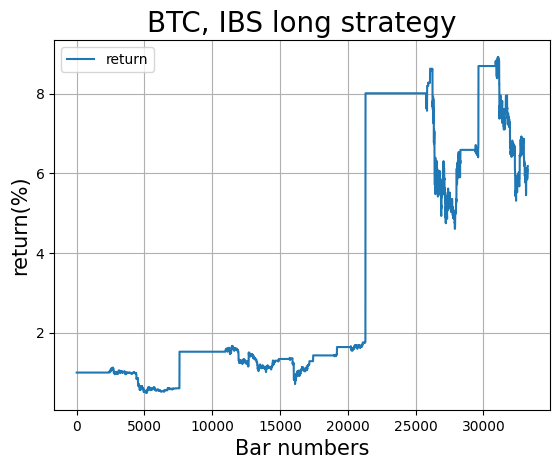

In [83]:
# Let's plot return
plt.plot(df['total'], label = 'return')
plt.ylabel('return', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS long strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

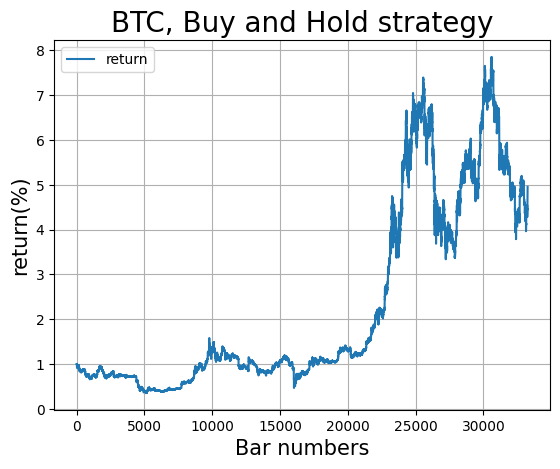

In [87]:
# compare it with buy and hold strategy
df['tomorrow_close'] = df['close'].shift(-1)
df['ror_buyandhold'] = df['tomorrow_close']/df['close']
df['ror_buyandhold'].fillna(1,inplace=True)
df['total_buyandhold'] = df['ror_buyandhold'].cumprod()

# plot return
plt.plot(df['total_buyandhold'], label = 'return')
plt.ylabel('return', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, Buy and Hold strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [88]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_buyandhold'].iat[-1] / df['total_buyandhold'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  395.62 return(%)


In [91]:
# calculate CAGR
total_profit = (df['total_buyandhold'].iat[-1] / df['total_buyandhold'].iat[0])
cagr = round((total_profit**(1/(trade_day/365))-1)*100,2)

# calculate MDD
arr_v = np.array(df['total_buyandhold'])
peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
peak_upper = np.argmax(arr_v[:peak_lower])

mdd = round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]*100,3)

print('CAGR:',cagr,'MDD:',mdd)

CAGR: 52.47 MDD: -51.75


# Let's test IBS short strategy

In [239]:
# short 진입청산 컬럼 생성
df['entry_short'] = np.where((df['short']==True)&(df['short_con']==True), 1.0,0.0) # 진입신호
df['exit_short'] = np.where(df['long']==True, 1.0,0.0) # 청산신호

In [240]:
# 포지션 보유 여부 컬럼 생성
df['position_short'] = df['entry_short'] - df['exit_short']

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position_short"]):
    # deal with edge case
    if lastseen == 0 and el == -1:
        df.loc[n,'position_short'] = 0
    
    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position_short"] = 0

In [241]:
df.loc[(df.position_short==1)|(df.position_short==-1),:]

,date,symbol,open,high,low,close,200SMA,100SMA,long,short,long_con,short_con,entry_short,exit_short,position_short
Bar numbers,,,,,,,,,,,,,,,
2446,2018-08-25 04:00:00,BTC/USD,6724.14,6745.75,6690.26,6738.99,NaN,6993.554733,False,True,True,True,1.0,0.0,1.0
2451,2018-08-25 09:00:00,BTC/USD,6708.17,6727.92,6682.93,6687.75,NaN,6990.205825,True,False,True,True,0.0,1.0,-1.0
2452,2018-08-25 10:00:00,BTC/USD,6687.75,6717.23,6682.23,6712.65,NaN,6989.541142,False,True,True,True,1.0,0.0,1.0
2462,2018-08-25 20:00:00,BTC/USD,6710.33,6724.99,6705.01,6705.09,NaN,6983.091367,True,False,True,True,0.0,1.0,-1.0
2473,2018-08-26 07:00:00,BTC/USD,6600.00,6636.00,6597.14,6634.00,NaN,6976.849063,False,True,True,True,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2021-12-01 16:00:00,BTC/USD,58690.42,59099.64,58448.18,58509.33,46080.161469,54308.085317,True,False,False,True,0.0,1.0,-1.0
31119,2021-12-01 21:00:00,BTC/USD,56814.71,57070.28,56469.22,57045.41,46089.815300,54324.588263,False,True,False,True,1.0,0.0,1.0
31158,2021-12-03 12:00:00,BTC/USD,57047.03,57242.89,56809.71,56854.87,46171.900323,54457.099471,True,False,True,True,0.0,1.0,-1.0


## Visualize

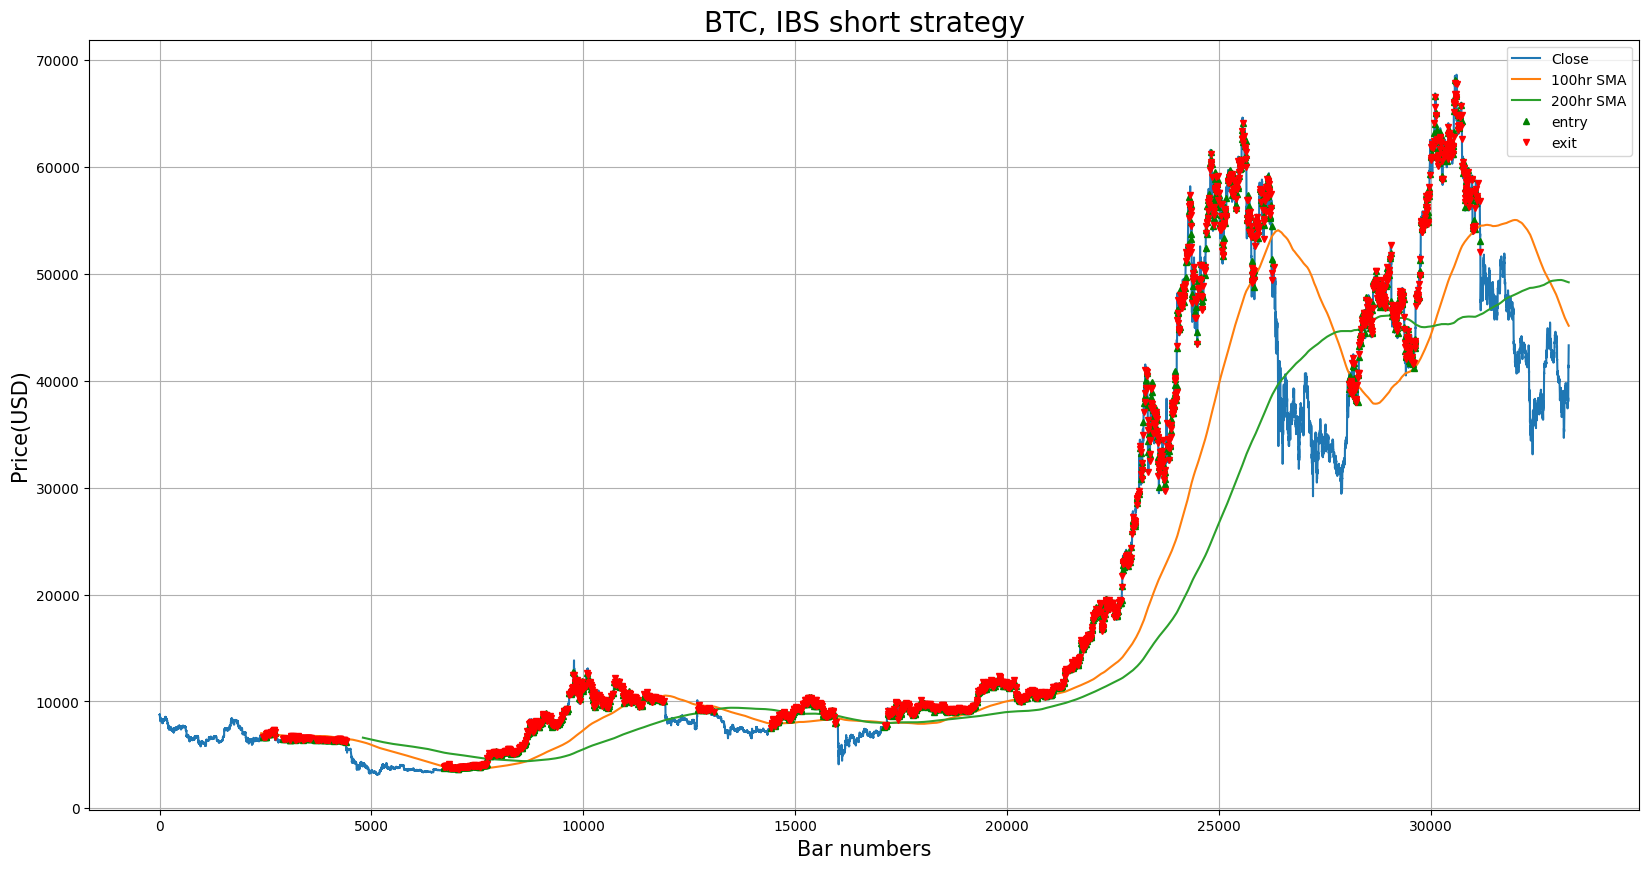

In [242]:
# plot close, 100SMA, 200SMA
df['close'].plot(figsize=(20,10), label='Close')
df['100SMA'].plot(label='100hr SMA')
df['200SMA'].plot(label='200hr SMA')

# plot 'entry' signals
plt.plot(df.loc[df['position_short']==1,:].index, df.loc[df['position_short']==1.0,'close'], '^', markersize = 5, color = 'g', label = 'entry')

# plot 'exit' signals
plt.plot(df.loc[df['position_short']==-1,:].index, df.loc[df['position_short']==-1.0,'close'], 'v', markersize = 5,  color = 'r', label = 'exit')
plt.ylabel('Price(USD)', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS short strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

## calculate the return

In [243]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position_short==1)|(df.position_short==-1),:]
df2['exit_close_short'] = df2['close'].shift(1)
# calculate return
df2['ror'] = df2['exit_close_short'] / df2['close']
df2.loc[df2['position_short']==1,'ror'] = 1

<ipython-input-243-4e76530c87d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_close_short'] = df2['close'].shift(1)
<ipython-input-243-4e76530c87d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ror'] = df2['exit_close_short'] / df2['close']
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [244]:
df['ror_short'] = df2['ror']
df['ror_short'].fillna(1,inplace=True)
# calculate accumulated ror
df['total_short'] = df['ror_short'].cumprod()

In [245]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_short'].iat[-1] / df['total_short'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  -45.145 return(%)


## Let's twist the short strategy

* In bull market, short strategy can jeaperdize our account and give us huge loss

* We have several method to avoid this

 1) Minimize holding period
 
 2) Trade only in bear market (ex. close < 100SMA)

 3) Trade only in volatile market

In [249]:
df = df1.copy()

In [250]:
# 진입조건을 위한 칼럼 생성
df['long'] = (df['close'] - df['low'])/(df['high'] - df['low']) < 0.2
df['short'] = (df['close'] - df['low'])/(df['high'] - df['low']) > 0.8

### Minimize holding period

In [251]:
# generate position column
# Create a new column called "position"
df["position_short"] = 0

# Set the value of "position" to 1 if "short" is True, and 0 if "long" is True
df.loc[df["short"] == True, "position_short"] = 1
df.loc[df["long"] == True, "position_short"] = -1

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position_short"]):
    # deal with edge case
    if lastseen == 0 and el == -1:
        df.loc[n,'position_short'] = 0

    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position_short"] = 0

# time cut apply
s = df['position_short']
out = s.where(s.eq(1)).mul(-1).shift(24).fillna(s).astype('int')
df['position_short'] = out


# remove duplicated position signal again
s_ = df['position_short'].mask(df['position_short']==0).ffill()
df['position_short'] = df['position_short'].where(s_ != s_.shift(), 0)

In [252]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position_short==1)|(df.position_short==-1),:]
df2['exit_close_short'] = df2['close'].shift(1)
# calculate return
df2['ror'] = df2['exit_close_short'] / df2['close']
df2.loc[df2['position_short']==1,'ror'] = 1

<ipython-input-252-4e76530c87d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_close_short'] = df2['close'].shift(1)
<ipython-input-252-4e76530c87d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ror'] = df2['exit_close_short'] / df2['close']
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [253]:
df['ror_short'] = df2['ror']
df['ror_short']= df['ror_short'].fillna(1)
# calculate accumulated ror
df['total_short'] = df['ror_short'].cumprod()

In [254]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_short'].iat[-1] / df['total_short'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  55.222 return(%)


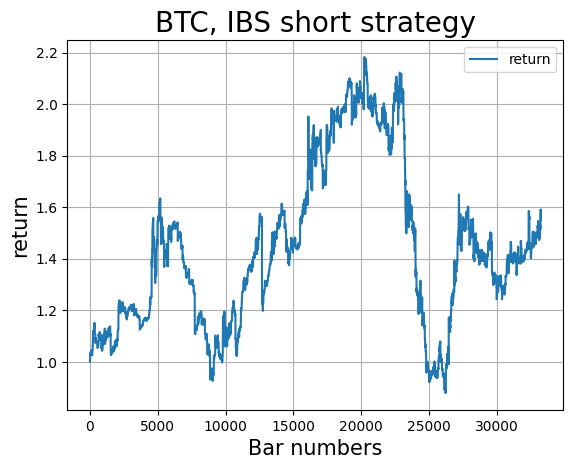

In [255]:
# Let's plot return
plt.plot(df['total_short'], label = 'return')
plt.ylabel('return', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS short strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### Trade only in bear market

* We can add condition to trade only in bear market

* First, we need to choose proper indicator to figure out the bear market

In [256]:
# 50SMA column
df['50SMA'] = df['close'].rolling(1200).mean()

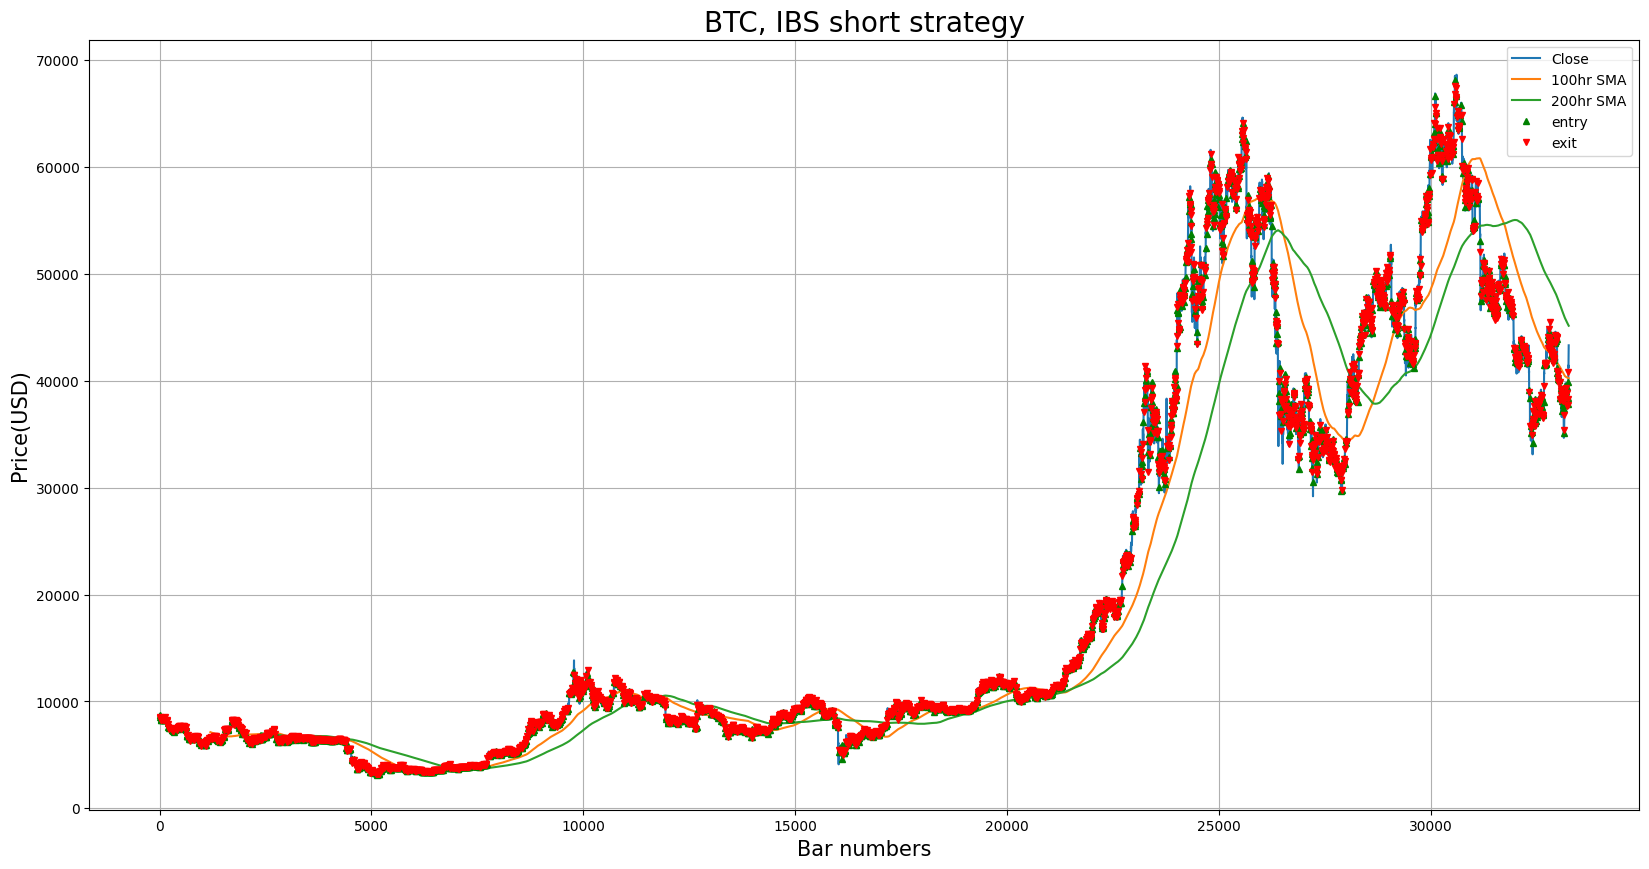

In [260]:
# plot close, 100SMA, 200SMA
df['close'].plot(figsize=(20,10), label='Close')
df['50SMA'].plot(label='100hr SMA')
df['100SMA'].plot(label='200hr SMA')

# plot 'entry' signals
plt.plot(df.loc[df['position_short']==1,:].index, df.loc[df['position_short']==1.0,'close'], '^', markersize = 5, color = 'g', label = 'entry')

# plot 'exit' signals
plt.plot(df.loc[df['position_short']==-1,:].index, df.loc[df['position_short']==-1.0,'close'], 'v', markersize = 5,  color = 'r', label = 'exit')
plt.ylabel('Price(USD)', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS short strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()